### Notes:

* python script stores result of the simulation in a predetermined location
* jupyter notebook shows visualizations of the results from solidity implementation and cadCAD model and error metrics

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import pandas as pd
import datetime as dt
from enum import Enum
import csv

import sys
sys.path.append('./models')

In [2]:
# market_price_df = pd.read_csv('./test/data/regression_market_prices.csv')
# market_price_df = pd.read_csv('./test/data/market_prices.csv')
# market_prices = market_price_df['market_price'].apply(lambda x: float(x)).to_list()

import csv
with open('./test/data/historic_market_prices.csv', newline='') as f:
    reader = csv.reader(f)
    market_prices = list(reader)[0]
    market_prices = [float(price) for price in market_prices]

# with open('./test/data/historic_market_prices.csv', 'w') as market_prices_csv:
#     wr = csv.writer(market_prices_csv, delimiter=',')
#     wr.writerow(market_prices)

In [3]:
#python stores a file containing Kp, Ki and a time series of market prices 
#(an array of tuples, or two arrays, containing a timestamp and the price, 
#or the time elapsed and the price change - we can go with whatever is easier to implement on the JS side)

#instead of file name being hardcoded, we could have it stored in an environment 
#variable that both python and JS read from
Kp = -1.5e-6 #-.25/3600/96
Ki = 0
    
length = len(market_prices)
delta_t = [3600] * length
SIMULATION_TIMESTEPS = length - 1

# save_dir = "./cross-model/truffle/test/saved_sims/pi_second/raw/custom-config-sim.txt"
save_dir = "../truffle/test/saved_sims/pi_second/raw/custom-config-sim.txt"

config_file = {
  "Kp": str(int(Kp*1e18)),
  "Ki": str(int(Ki*1e18)),
  "noise_barrier": "1000000000000000000",
  "per_second_leak": "1000000000000000000000000000",
  "oracle_initial_price": "2000000000000000000",
  "initial_redemption_price": "2000000000000000000000000000",
  "delta_t": [str(i) for i in delta_t],
  "market_prices": [str(int(i*1e18)) for i in market_prices],
  "save_dir": save_dir
}

import json
with open('./cross-model/truffle/test/config/pi_second_raw.json', 'w') as fp:
    json.dump(config_file, fp)
    
config_file = {
  "kp": Kp,
  "ki": lambda control_period=3600: Ki/control_period,
  #"noise_barrier": 1000000000000000000,
  #"per_second_leak": 1000000000000000000000000000,
  #"oracle_initial_price": 2000000000000000000,
  #"initial_redemption_price": 2000000000000000000000000000,
  "delta_t": delta_t,
  "market_prices": market_prices,
}

In [4]:
market_prices[0:5]

[2.03520968321892,
 2.00675297061406,
 2.02594470965992,
 2.05147525236802,
 1.94445601467646]

In [5]:
# Compile, test, and deploy contracts to Ganache
# !npm run pi-raw-second-imported-config --prefix './cross-model/truffle'

import os
os.chdir('./cross-model/truffle')
!npm run pi-raw-second-imported-config
import os
os.chdir('../../')


> geb-rrfm-truffle-sims@1.0.0 pi-raw-second-imported-config /Users/bscholtz/workspace/reflexer/cross-model/truffle
> npx truffle test test/pi_raw_second_imported_config.js

░░░░⠂⠂⠂⠂⠂⠂⸩ ⠹ install:ansi-styles: info lifecycle ansi-styles@3.2.1~in- Fetching solc version list from solc-bin. Attempt #1

Compiling your contracts...
> Compiling ./cross-model/truffle/contracts/Migrations.sol
> Compiling ./cross-model/truffle/contracts/mock/AGUpdater.sol
> Compiling ./cross-model/truffle/contracts/mock/MockOracleRelayer.sol
> Compiling ./cross-model/truffle/contracts/mock/MockRateSetter.sol
> Compiling ./cross-model/truffle/contracts/mock/MockTreasury.sol
> Compiling ./cross-model/truffle/contracts/mock/SeedProposerUpdater.sol
> Compiling ./cross-model/truffle/contracts/oracle/MockFeed.sol
> Compiling ./cross-model/truffle/contracts/setter/RateSetter.sol
> Compiling ./cross-model/truffle/contracts/setter/RateSetterMath.sol
> Compiling ./cross-model/truffle/contracts/token/Address.sol
> Compilin

[redemptionRate](https://github.com/reflexer-labs/geb-rrfm-truffle-sims/blob/master/contracts/mock/MockOracleRelayer.sol#L14) = $1+d_t$ (units: per second)  
$p_{t+\Delta{t}} = p_{t} (1+d_t)^{\Delta{t}}$ where $\Delta{t}$ is measured in seconds  
Meaning:
* $d_t > 0$ implies $redemptionRate > 1$  
* $d_t < 0$ implies $redemptionRate < 1$  


In the results dataset this is the PerSecondRedemptionRate column

In [6]:
from models.system_model.model.state_variables import state_variables

def pre_process_initial_conditions(genesis_dict):
    base_genesis_states = genesis_dict.copy()
    for k in base_genesis_states.keys():
        if k in config_file:
            try:
                base_genesis_states[k] = config_file[k][0]
            except:
                base_genesis_states[k] = config_file[k]
    return base_genesis_states

test_specific_initial_conditions = pre_process_initial_conditions(state_variables)

In [7]:
from models.system_model.model.parts.sys_params import params

def pre_process_params_dict(params_dict):
    base_params_dict = params_dict.copy()
    for k in config_file.keys():
        if type(config_file[k]) == list:
            base_params_dict[k] = [config_file[k]]
        else:
            try:
                base_params_dict[k] = [config_file[k]]
            except OverflowError:
                print(config_file[k])
                raise
    return base_params_dict

test_specific_params = pre_process_params_dict(params)

In [8]:
# T = 0
# for k in config_file.keys():
#     if type(config_file[k]) == list:
#         T = len(config_file[k])-1
#         break

In [9]:
def test_specific_resolve_time_passed(params, substep, state_history, state):
    index = state['timestep']+1
    value = params['delta_t'][index]
    return {'seconds_passed': value}

def test_specific_update_market_price(params, substep, state_history, state, policy_input):
    key = 'market_price'  
    index = state['timestep']
    value = params['market_prices'][index]
    return key, value


from models.system_model.model.parts.markets import resolve_time_passed, update_market_price
from models.system_model.model.partial_state_update_blocks import partial_state_update_blocks

for psub in partial_state_update_blocks:
    for psub_part in psub.values():
        if type(psub_part)==dict:
            for k,v in psub_part.items():
                if v == resolve_time_passed:
                    psub_part[k] = test_specific_resolve_time_passed
                if v == update_market_price:
                    psub_part[k] = test_specific_update_market_price

In [10]:
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

del configs[:]

exp = Experiment()

sim_config_dict = {
    'T': range(SIMULATION_TIMESTEPS),
    'N': 1,
    'M': test_specific_params
}
c = config_sim(sim_config_dict)

exp.append_configs(
    initial_state=test_specific_initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=c #preprocessed dictionaries containing simulation parameters
)

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)
executor = Executor(local_mode_ctx, configs) # Pass the configuration object inside an array
raw_result, tensor, sessions = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (651, 24, 1, 15)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.44s


In [11]:
full = pd.DataFrame(raw_result)

In [12]:
max_substep = max(full.substep)
df = full.copy()
df = df[(df.substep==max_substep) | (df.substep==0)]

In [13]:
save_dir = "./cross-model/truffle/test/saved_sims/pi_second/raw/custom-config-sim.txt"
data = pd.read_csv(save_dir, sep=" ", header=None, skiprows=1)
data.columns = [x.replace(' ','') for x in pd.read_csv(save_dir, sep="|", nrows=1).columns]

for c in data.columns:
    data[c]=data[c].apply(float)
#define normalizing constants
WAD = 10**18
RAY = 10**27
RAD = 10**45
#normalize data to "USD" dimension
data['MarketPrice(USD)'] = data['MarketPrice(WAD)']/WAD
data['RedemptionPrice(USD)'] = data['RedemptionPrice(RAY)']/RAY
data['PerSecondRedemptionRate(float)'] = data['PerSecondRedemptionRate(RAY)']/RAY - 1
data['time'] = data['DelaySinceLastUpdate'].cumsum()
data['timestamp'] = state_variables['timestamp'] + data['time'].apply(lambda x: dt.timedelta(seconds=x))

In [14]:
df

,error_star,error_hat,old_error_star,old_error_hat,error_star_integral,error_hat_integral,error_star_derivative,error_hat_derivative,target_rate,target_price,market_price,debt_price,timedelta,timestamp,blockheight,simulation,subset,run,substep,timestep
0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000,2.000000,2.000000,0,2018-12-18 00:00:00,0,0,0,1,0,0
6,-0.006753,-0.005694,0.0,0.0,-12.155347,-10.249906,-0.000002,-0.000002,1.012946e-08,2.000073,2.006753,2.001059,3600,2018-12-18 01:00:00,240,0,0,1,6,1
12,-0.025872,-0.024404,0.0,0.0,-70.724544,-64.427379,-0.000005,-0.000005,3.880766e-08,2.000352,2.025945,2.001541,3600,2018-12-18 02:00:00,480,0,0,1,6,2
18,-0.051123,-0.051069,0.0,0.0,-208.590371,-200.279890,-0.000007,-0.000007,7.668431e-08,2.000905,2.051475,2.000406,3600,2018-12-18 03:00:00,720,0,0,1,6,3
24,0.056449,0.056848,0.0,0.0,-197.413578,-189.877749,0.000030,0.000030,-8.467300e-08,2.000295,1.944456,2.001304,3600,2018-12-18 04:00:00,960,0,0,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3882,-0.038813,-0.016180,0.0,0.0,-2704.509687,35317.836081,-0.000005,-0.000005,5.821935e-08,2.004417,2.042810,2.026629,3600,2019-01-13 23:00:00,155280,0,0,1,6,647
3888,-0.010274,0.012296,0.0,0.0,-2781.357167,35310.844974,0.000008,0.000008,1.541163e-08,2.004528,2.014691,2.026987,3600,2019-01-14 00:00:00,155520,0,0,1,6,648
3894,-0.017485,0.004026,0.0,0.0,-2818.966569,35340.225110,-0.000002,-0.000002,2.622718e-08,2.004717,2.022013,2.026039,3600,2019-01-14 01:00:00,155760,0,0,1,6,649
3900,-0.022490,-0.001219,0.0,0.0,-2878.955449,35345.277225,-0.000001,-0.000001,3.373569e-08,2.004961,2.027208,2.025988,3600,2019-01-14 02:00:00,156000,0,0,1,6,650


In [15]:
data

,MarketPrice(WAD),RedemptionPrice(RAY),RedemptionRate(%),PerSecondRedemptionRate(RAY),RedemptionRateTimeline(Seconds),Proportional(NoGain),Proportional(WithGain),Integral(NoGain),Integral(WithGain),DelaySinceLastUpdate,MarketPrice(USD),RedemptionPrice(USD),PerSecondRedemptionRate(float),time,timestamp
0,2.035210e+18,2.000000e+27,1.0,1.000000e+27,1.0,-3.520968e+25,5.281452e+19,0.000000e+00,0.0,3600.0,2.035210,2,5.28145e-08,3600.0,2018-12-18 01:00:00
1,2.006753e+18,2.000380e+27,1.0,1.000000e+27,1.0,-6.372564e+24,9.558846e+18,-7.486884e+28,0.0,3600.0,2.006753,2.00038,9.55885e-09,7200.0,2018-12-18 02:00:00
2,2.025945e+18,2.000449e+27,1.0,1.000000e+27,1.0,-2.549547e+25,3.824320e+19,-1.322313e+29,0.0,3600.0,2.025945,2.00045,3.82432e-08,10800.0,2018-12-18 03:00:00
3,2.051475e+18,2.000725e+27,1.0,1.000000e+27,1.0,-5.075058e+25,7.612586e+19,-2.694742e+29,0.0,3600.0,2.051475,2.00072,7.61259e-08,14400.0,2018-12-18 04:00:00
4,1.944456e+18,2.001273e+27,1.0,9.999999e+26,1.0,5.681704e+25,-8.522556e+19,-2.585545e+29,0.0,3600.0,1.944456,2.00127,-8.52256e-08,18000.0,2018-12-18 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,2.042810e+18,2.003998e+27,1.0,1.000000e+27,1.0,-3.881118e+25,5.821678e+19,-1.338099e+30,0.0,3600.0,2.042810,2.004,5.82168e-08,2332800.0,2019-01-14 00:00:00
648,2.014691e+18,2.004418e+27,1.0,1.000000e+27,1.0,-1.027272e+25,1.540908e+19,-1.426450e+30,0.0,3600.0,2.014691,2.00442,1.54091e-08,2336400.0,2019-01-14 01:00:00
649,2.022013e+18,2.004530e+27,1.0,1.000000e+27,1.0,-1.748300e+25,2.622449e+19,-1.476434e+30,0.0,3600.0,2.022013,2.00453,2.62245e-08,2340000.0,2019-01-14 02:00:00
650,2.027208e+18,2.004719e+27,1.0,1.000000e+27,1.0,-2.248866e+25,3.373299e+19,-1.548397e+30,0.0,3600.0,2.027208,2.00472,3.3733e-08,2343600.0,2019-01-14 03:00:00


In [16]:
combined = df.merge(data, how='inner', on=['timestamp'])
combined = combined.iloc[25:]
combined

,error_star,error_hat,old_error_star,old_error_hat,error_star_integral,error_hat_integral,error_star_derivative,error_hat_derivative,target_rate,target_price,...,RedemptionRateTimeline(Seconds),Proportional(NoGain),Proportional(WithGain),Integral(NoGain),Integral(WithGain),DelaySinceLastUpdate,MarketPrice(USD),RedemptionPrice(USD),PerSecondRedemptionRate(float),time
25,-0.013579,-0.020861,0.0,0.0,-2523.233639,-2575.380793,-6.736330e-06,-6.736330e-06,2.036877e-08,2.008010,...,1.0,1.096657e+25,-1.644985e+19,-2.669113e+30,0.0,3600.0,1.997307,2.00827,-1.64499e-08,93600.0
26,-0.003380,-0.010300,0.0,0.0,-2542.526941,-2631.470599,2.833042e-06,2.833042e-06,5.070345e-09,2.008047,...,1.0,-1.328737e+25,1.993106e+19,-2.673295e+30,0.0,3600.0,2.021442,2.00816,1.99311e-08,97200.0
27,0.001741,-0.006494,0.0,0.0,-2534.950771,-2661.699364,1.422539e-06,1.422539e-06,-2.611368e-09,2.008028,...,1.0,-3.091562e+24,4.637343e+18,-2.702777e+30,0.0,3600.0,2.011391,2.0083,4.63734e-09,100800.0
28,0.029813,0.019764,0.0,0.0,-2467.203337,-2637.812815,7.797744e-06,7.797744e-06,-4.471918e-08,2.007705,...,1.0,2.026455e+24,-3.039682e+18,-2.704694e+30,0.0,3600.0,2.006306,2.00833,-3.03968e-09,104400.0
29,0.032301,0.021561,0.0,0.0,-2345.196075,-2563.427851,6.910314e-07,6.910314e-07,-4.845075e-08,2.007355,...,1.0,3.009523e+25,-4.514284e+19,-2.646859e+30,0.0,3600.0,1.978215,2.00831,-4.51428e-08,108000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,-0.038813,-0.016180,0.0,0.0,-2704.509687,35317.836081,-5.434683e-06,-5.434683e-06,5.821935e-08,2.004417,...,1.0,-1.924637e+25,2.886955e+19,-1.233566e+30,0.0,3600.0,2.023036,2.00379,2.88696e-08,2329200.0
647,-0.010274,0.012296,0.0,0.0,-2781.357167,35310.844974,7.927356e-06,7.927356e-06,1.541163e-08,2.004528,...,1.0,-3.881118e+25,5.821678e+19,-1.338099e+30,0.0,3600.0,2.042810,2.004,5.82168e-08,2332800.0
648,-0.017485,0.004026,0.0,0.0,-2818.966569,35340.225110,-2.002880e-06,-2.002880e-06,2.622718e-08,2.004717,...,1.0,-1.027272e+25,1.540908e+19,-1.426450e+30,0.0,3600.0,2.014691,2.00442,1.54091e-08,2336400.0
649,-0.022490,-0.001219,0.0,0.0,-2878.955449,35345.277225,-1.390465e-06,-1.390465e-06,3.373569e-08,2.004961,...,1.0,-1.748300e+25,2.622449e+19,-1.476434e+30,0.0,3600.0,2.022013,2.00453,2.62245e-08,2340000.0


/Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecati

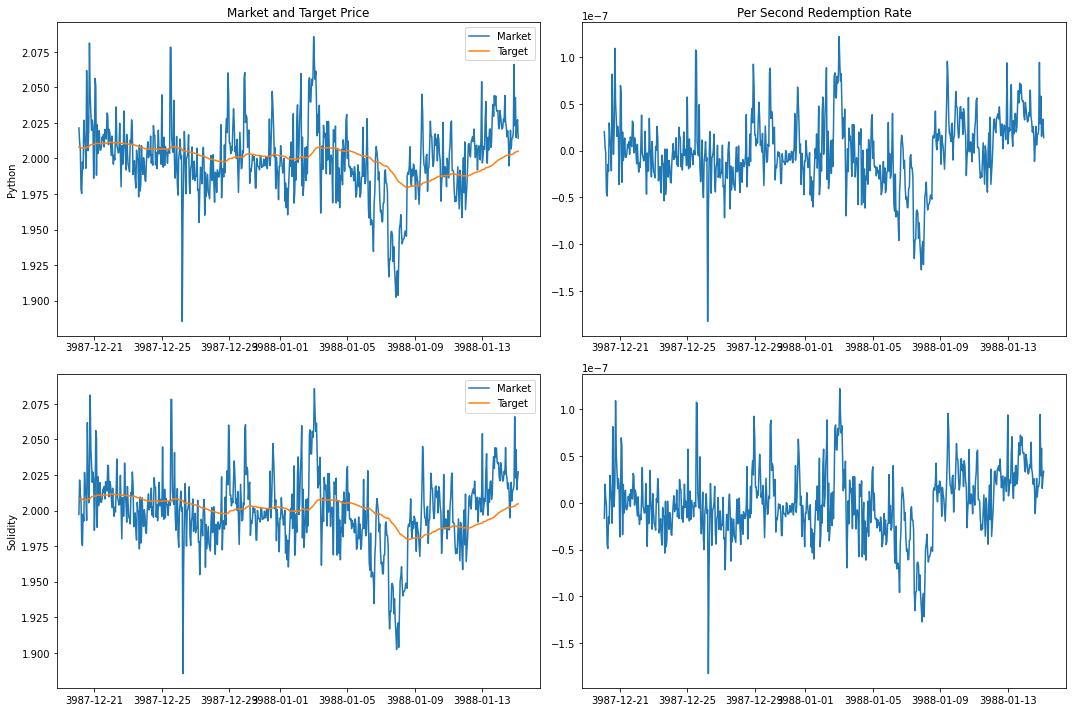

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15,10))

i = 0
axs.flat[i].plot(combined['timestamp'], combined['market_price'], label='Market')
axs.flat[i].plot(combined['timestamp'], combined['target_price'], label='Target')
axs.flat[i].set_ylabel('Python')
axs.flat[i].set_title('Market and Target Price')
axs.flat[i].legend()

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['target_rate'])
axs.flat[i].set_title('Per Second Redemption Rate')

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['MarketPrice(USD)'], label='Market')
axs.flat[i].plot(combined['timestamp'], combined['RedemptionPrice(USD)'], label='Target')
axs.flat[i].legend()
axs.flat[i].set_ylabel('Solidity')

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['PerSecondRedemptionRate(float)'])

fig.tight_layout()
plt.show()
fig.savefig('plots/solidity-cadcad/solidity-cadcad-market.png')

<AxesSubplot:>

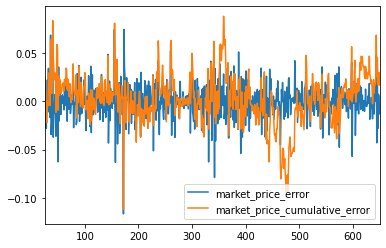

In [22]:
combined['market_price_error'] = combined['market_price'] - combined['MarketPrice(USD)']
combined['market_price_error'].plot(legend=True)
combined['market_price_cumulative_error'] = combined['market_price_error'].cumsum()
combined['market_price_cumulative_error'].plot(legend=True)

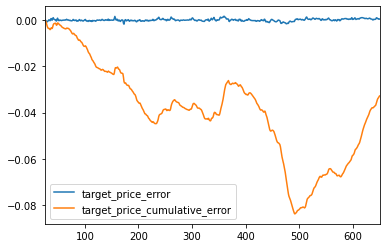

In [24]:
combined['target_price_error'] = combined['target_price'] - combined['RedemptionPrice(USD)']
combined['target_price_error'].plot(legend=True)
combined['target_price_cumulative_error'] = combined['target_price_error'].cumsum()
combined['target_price_cumulative_error'].plot(legend=True)
plt.savefig('plots/solidity-cadcad/solidity-cadcad-error.png')

In [26]:
print(f'''
Max error: {combined['target_price_error'].max()}
Std. error: {combined['target_price_error'].std()}
Mean error: {combined['target_price_error'].mean()}
Abs. mean error: {combined['target_price_error'].abs().mean()}
''')


Max error: 0.001549358635118292
Std. error: 0.000493563911806611
Mean error: -5.243893138066842e-05
Abs. mean error: 0.00037834760494943686



In [27]:
combined['target_price_cumulative_error'].describe()

count     626.000000
unique    626.000000
top        -0.035055
freq        1.000000
Name: target_price_cumulative_error, dtype: float64